In [1]:
from project_lib.genotype_simulation import *
from project_lib.stat_functions import *
import tskit
import msprime
import stdpopsim
import networkx as nx
import matplotlib.pyplot as plt
import io
from IPython.display import display as SVG
import pandas as pd
import numpy as np
from typing import List, Tuple, Dict
from decimal import *
import scipy.stats as stats
import seaborn as sns
import decimal

C:\Users\PHLUP\miniconda3\envs\masterarbeit\Lib\site-packages\stdpopsim\catalog\HomSap\demographic_models.py:158: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  time=int(extended_GF.time.head(1) - 1), rate=0
C:\Users\PHLUP\miniconda3\envs\masterarbeit\Lib\site-packages\stdpopsim\catalog\HomSap\demographic_models.py:161: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  time=int(extended_GF.time.tail(1) + 1), rate=0


In [103]:
#read genetic map
genmap = pd.read_csv("../data/sim_data/B73_genmap.csv")
#read parent genotypes
parent_genos = pd.read_csv("../data/sim_data/NAM_parent_genos.csv")
#read reference allele
ref_allele = pd.read_csv("../data/sim_data/B73_alleles.csv")
# read population names
populations = pd.read_csv("../data/sim_data/populations.csv")

In [12]:
whole_sim = genotype_simulation(genetic_map = genmap, parent_genos = parent_genos, ref_allele = ref_allele, 
                                founder_list = list(["B73", "B97"]), offspring = 3, selfing_genos = 5)

starting simulation
finished chromsome 1
finished chromsome 2
finished chromsome 3
finished chromsome 4
finished chromsome 5
finished chromsome 6
finished chromsome 7
finished chromsome 8
finished chromsome 9
finished chromsome 10


In [15]:
def genotype_simulation(genetic_map: pd.DataFrame, parent_genos: pd.DataFrame, ref_allele: pd.DataFrame,
                        founder_list: List[str], offspring: int, selfing_genos: int = 5) -> (pd.DataFrame, List[tskit.TreeSequence]):
    """
    Simulate genotypes based on the given parameters.

    Parameters:
        genetic_map (pd.DataFrame): DataFrame containing genetic map information.
        parent_genos (pd.DataFrame): DataFrame containing genotypes of parent individuals.
        ref_allele (pd.DataFrame): DataFrame containing reference alleles.
        founder_list (List[str]): List of two founder names.
        offspring (int): Number of offspring.
        selfing_genos (int): Number of selfing generations.

    Returns:
        pd.DataFrame: DataFrame containing simulated genotypes.
        List[tskit.TreeSequence]: List containing ARGs of the simulated pedigree per chromosome.
    """
    #get founder nodes
    founder_nodes = get_founder_nodes(parent_genos, founder_list)
    #reduce ref_alleles to alleles in genmap
    ref_allele = ref_allele[ref_allele["SNP"].isin(genetic_map["Marker"])]
    #set up pedigree
    pedigree = cross_selfing_ped(offspring = offspring, selfing_genos = selfing_genos)
    #init final genotypes dataframe
    genotypes = pd.DataFrame({"individual": pedigree.loc[pedigree["time"] == 0, "id"]})
    #init final ARG list
    ARGs = list()
    #loop over each chromosome, append results (treats chromosomes entirely independent)
    #possible to parallelise due to independence of tasks
    print("starting simulation")
    for i in genetic_map["Chromosome"].unique():
        #reduce genetic map to chr_i
        chr_genmap = genetic_map.loc[genetic_map["Chromosome"] == i]
        #set up rate map for chr_i
        chr_rate_map = get_rate_map(chr_genmap)
        #get chr_i length
        chr_len = chr_genmap["Position(bp)"].max()
        #turn pedigree into ts with chr_i length
        chr_ts = df_to_ts(pedigree, seq_len=chr_len)
        #simulate chr_i ARG
        chr_arg = msprime.sim_ancestry(initial_state = chr_ts, model="fixed_pedigree", recombination_rate = chr_rate_map)
        #propagate ARG recombinations to offspring genotypes
        chr_geno_sim = propagate_geno(chr_arg, founder_nodes, chr_genmap)
        #join haploid offspring simulation nodes to diploid individuals
        chr_genotypes = join_nodes(chr_arg, chr_geno_sim)
        #merge chr_i genotypes to final genotypes
        genotypes = pd.merge(genotypes, chr_genotypes, on = "individual", how = "inner")
        #append ARG to arg list
        ARGs.append(chr_arg)
        print(f"finished chromsome {i}")

In [104]:
genetic_map = genmap
parent_genos = parent_genos
ref_allele = ref_allele
founder_list = list(["B73", "B97"])
offspring = 3
selfing_genos = 5

In [105]:
founder_nodes = get_founder_nodes(parent_genos, founder_list)
#reduce ref_alleles to alleles in genmap
ref_allele = ref_allele[ref_allele["SNP"].isin(genetic_map["Marker"])]
#set up pedigree
pedigree = cross_selfing_ped(offspring = offspring, selfing_genos = selfing_genos)
#init final genotypes dataframe
genotypes = pd.DataFrame({"individual": pedigree.loc[pedigree["time"] == 0, "id"]})
#init final ARG list
ARGs = list()

In [106]:
i = 1

In [107]:
#reduce genetic map to chr_i
chr_genmap = genetic_map.loc[genetic_map["Chromosome"] == i]
#set up rate map for chr_i
chr_rate_map = get_rate_map(chr_genmap)
#get chr_i length
chr_len = chr_genmap["Position(bp)"].max()
#turn pedigree into ts with chr_i length
chr_ts = df_to_ts(pedigree, seq_len=chr_len)
#simulate chr_i ARG
chr_arg = msprime.sim_ancestry(initial_state = chr_ts, model="fixed_pedigree", recombination_rate = chr_rate_map)


In [95]:
arg = chr_arg
genmap = chr_genmap

In [96]:
sites = genmap["Marker"]
geno_sim = pd.DataFrame(columns = list(["node"]) + list(sites))
geno_sim["node"] = get_set(arg)
founders = get_founders(arg)
founder_nodes = founder_nodes[sites]

for i in range(0, len(founders)):
    geno_sim.loc[geno_sim["node"] == founders[i], sites] = list(founder_nodes.iloc[founders[i]])
edges = get_edges(founders, arg)

In [97]:
edges

,left,right,parent,child
56,39504423.0,75809719.0,0,15
57,1947984.0,4527766.0,0,17
58,37703895.0,39504423.0,0,27
59,75809719.0,186258190.0,0,27
60,186258190.0,257637066.0,0,32
61,201306819.0,210847521.0,1,4
62,260417595.0,269461651.0,1,10
63,296308240.0,297570924.0,1,12
64,11418567.0,11863868.0,1,15
65,13960242.0,16243248.0,1,15


In [98]:
geno_sim

,node,PZA01271.1,PZA03613.1,PZA02129.1,PZA02032.1,PHM2244.142,PZA02372.1,PHM6238.36,PZA00181.2,PZA00528.1,...,PZA02359.10,PHM9807.9,PZA01068.1,PZA00343.31,PHM1275.22,PZA00243.25,PZA00856.2,PZA01239.2,PZA01807.1,PZA00432.4
0,0,C,A,T,T,C,T,A,G,A,...,T,C,C,A,A,G,T,A,G,C
1,1,C,A,T,T,C,T,A,G,A,...,T,C,C,A,A,G,T,A,G,C
2,2,G,T,C,A,G,T,A,T,C,...,T,G,C,G,C,A,T,A,G,T
3,3,G,T,C,A,G,T,A,T,C,...,T,G,C,G,C,A,T,A,G,T
4,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [99]:
for i in range(0, len(edges["parent"])):
    snps = genmap.loc[(genmap['Position(bp)'] >= edges.iloc[i]["left"]) & (genmap['Position(bp)'] <= edges.iloc[i]["right"]), "Marker"]
    geno_sim.loc[geno_sim["node"] == edges.iloc[i]["child"], snps] = geno_sim.loc[geno_sim["node"] == edges.iloc[i]["parent"], snps].values[0]
edges = get_edges(edges["child"], arg)

In [100]:
geno_sim

,node,PZA01271.1,PZA03613.1,PZA02129.1,PZA02032.1,PHM2244.142,PZA02372.1,PHM6238.36,PZA00181.2,PZA00528.1,...,PZA02359.10,PHM9807.9,PZA01068.1,PZA00343.31,PHM1275.22,PZA00243.25,PZA00856.2,PZA01239.2,PZA01807.1,PZA00432.4
0,0,C,A,T,T,C,T,A,G,A,...,T,C,C,A,A,G,T,A,G,C
1,1,C,A,T,T,C,T,A,G,A,...,T,C,C,A,A,G,T,A,G,C
2,2,G,T,C,A,G,T,A,T,C,...,T,G,C,G,C,A,T,A,G,T
3,3,G,T,C,A,G,T,A,T,C,...,T,G,C,G,C,A,T,A,G,T
4,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A,G,C
7,15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,17,C,A,T,T,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [101]:
edges

,left,right,parent,child
0,5172685.0,47764293.0,28,34
1,5172685.0,47764293.0,28,35
2,1947984.0,4835209.0,31,36
3,256108134.0,258259662.0,31,36
4,1947984.0,4835209.0,31,37
5,256108134.0,258259662.0,31,37
6,186258190.0,290223292.0,32,38
7,186258190.0,290223292.0,32,39
8,1947984.0,3863636.0,33,38
9,294011299.0,297570924.0,33,38


In [88]:
#while edges.empty != True:
#    for i in range(0, len(edges["parent"])):
#        snps = genmap.loc[(genmap['Position(bp)'] >= edges.iloc[i]["left"]) & (genmap['Position(bp)'] <= edges.iloc[i]["right"]), "Marker"]
#        geno_sim.loc[geno_sim["node"] == edges.iloc[i]["child"], snps] = geno_sim.loc[geno_sim["node"] == edges.iloc[i]["parent"], snps].values[0]
#    edges = get_edges(edges["child"], arg)

In [89]:
edges

,left,right,parent,child


In [77]:
chr_geno_sim = geno_sim

In [110]:
chr_geno_sim = propagate_geno(chr_arg, founder_nodes, chr_genmap)
#join haploid offspring simulation nodes to diploid individuals
chr_genotypes = join_nodes(chr_arg, chr_geno_sim)
#merge chr_i genotypes to final genotypes
genotypes = pd.merge(genotypes, chr_genotypes, on = "individual", how = "inner")
#append ARG to arg list
ARGs.append(chr_arg)

TypeError: string indices must be integers, not 'str'

In [79]:
chr_geno_sim

,node,PZA01271.1,PZA03613.1,PZA02129.1,PZA02032.1,PHM2244.142,PZA02372.1,PHM6238.36,PZA00181.2,PZA00528.1,...,PZA02359.10,PHM9807.9,PZA01068.1,PZA00343.31,PHM1275.22,PZA00243.25,PZA00856.2,PZA01239.2,PZA01807.1,PZA00432.4
0,0,C,A,T,T,C,T,A,G,A,...,T,C,C,A,A,G,T,A,G,C
1,1,C,A,T,T,C,T,A,G,A,...,T,C,C,A,A,G,T,A,G,C
2,2,G,T,C,A,G,T,A,T,C,...,T,G,C,G,C,A,T,A,G,T
3,3,G,T,C,A,G,T,A,T,C,...,T,G,C,G,C,A,T,A,G,T
4,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,T,G,C,G,C,A,T,A,G,T
7,20,G,T,C,A,G,T,A,T,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [80]:
genotypes

,individual,PZA01271.1,PZA03613.1,PZA02129.1,PZA02032.1,PHM2244.142,PZA02372.1,PHM6238.36,PZA00181.2,PZA00528.1,...,PZA02359.10,PHM9807.9,PZA01068.1,PZA00343.31,PHM1275.22,PZA00243.25,PZA00856.2,PZA01239.2,PZA01807.1,PZA00432.4
0,17,CC,AA,CC,AA,GG,TT,AA,TT,CC,...,TT,GG,CC,GG,CC,AA,TT,AA,GG,TT
1,18,CC,AA,TT,TT,CC,TT,AA,GG,AA,...,TT,GG,CC,GG,CC,AA,TT,AA,GG,TT
2,19,GG,TT,CC,AA,GG,TT,AA,TT,CC,...,TT,CC,CC,AA,AA,GG,TT,AA,GG,CC


In [111]:
def propagate_geno(arg: tskit.TreeSequence, founder_nodes: pd.DataFrame, genmap: pd.DataFrame) -> List[Dict]:
    """
    Propagate genotypes through the tree sequence/ARG.

    Parameters:
        arg (tskit.TreeSequence): TreeSequence object obtained from msprime.sim_ancestry.
        founder_nodes (pd.DataFrame): DataFrame containing founder nodes.
        genmap (pd.DataFrame): DataFrame containing genetic map.

    Returns:
        List[Dict]: List of dictionaries containing propagated genotypes.
    """
    sites = genmap["Marker"]
    geno_sim = []

    for node in get_set(arg):
        geno_dict = {"node": node}
        founders = get_founders(arg)
        founder_nodes_subset = founder_nodes.loc[founders, sites].to_dict(orient='records')[0] if node in founders else None

        for i in range(len(founders)):
            if node == founders[i]:
                geno_dict.update({site: founder_nodes_subset[site] for site in sites})

        edges = get_edges(founders, arg)

        while edges.empty != True:
            for i in range(len(edges)):
                snps = genmap.loc[
                    (genmap['Position(bp)'] >= edges.iloc[i]["left"]) & (genmap['Position(bp)'] <= edges.iloc[i]["right"]),
                    "Marker"]
                parent_genotype = next(
                    (d for d in geno_sim if d["node"] == edges.iloc[i]["parent"]), None)
                if parent_genotype:
                    geno_dict.update({site: parent_genotype[site] for site in snps})
            edges = get_edges(edges["child"], arg)

        geno_sim.append(geno_dict)

    return geno_sim

In [35]:
def propagate_geno(arg: tskit.TreeSequence, founder_nodes: pd.DataFrame, genmap: pd.DataFrame) -> pd.DataFrame:
    """
    Propagate genotypes through the tree sequence/ARG.

    Parameters:
        arg (tskit.TreeSequence): TreeSequence object obtained from msprime.sim_ancestry.
        founder_nodes (pd.DataFrame): DataFrame containing founder nodes.
        genmap (pd.DataFrame): DataFrame containing genetic map.

    Returns:
        pd.DataFrame: DataFrame containing propagated genotypes.
    """
    sites = genmap["Marker"]
    node_set = get_set(arg)
    founders = get_founders(arg)
    founder_nodes = founder_nodes[sites].values

    geno_sim_dict = {"node": node_set}

    for founder in founders:
        geno_sim_dict[founder] = list(founder_nodes[founder])

    edges = get_edges(founders, arg)

    while not edges.empty:
        for i in range(len(edges["parent"])):
            parent_node = edges.iloc[i]["parent"]
            child_node = edges.iloc[i]["child"]
            snps = genmap.loc[(genmap['Position(bp)'] >= edges.iloc[i]["left"]) & (genmap['Position(bp)'] <= edges.iloc[i]["right"]), "Marker"]

            geno_sim_dict[child_node] = geno_sim_dict[parent_node].copy()
            for snp in snps:
                index_snp = sites[sites == snp].index[0]
                geno_sim_dict[child_node][index_snp] = geno_sim_dict[parent_node][index_snp]

        edges = get_edges(edges["child"], arg)

    geno_sim = pd.DataFrame(geno_sim_dict)
    return geno_sim

In [ ]:
def propagate_geno(arg: tskit.TreeSequence, founder_nodes: pd.DataFrame, genmap: pd.DataFrame) -> pd.DataFrame:
    """
    Propagate genotypes through the tree sequence/ARG.

    Parameters:
        arg (tskit.TreeSequence): TreeSequence object obtained from msprime.sim_ancestry.
        founder_nodes (pd.DataFrame): DataFrame containing founder nodes.
        genmap (pd.DataFrame): DataFrame containing genetic map.

    Returns:
        pd.DataFrame: DataFrame containing propagated genotypes.
    """
    sites = genmap["Marker"]
    geno_sim = pd.DataFrame(columns = list(["node"]) + list(sites))
    geno_sim["node"] = get_set(arg)
    founders = get_founders(arg)
    founder_nodes = founder_nodes[sites]
    
    for i in range(0, len(founders)):
        geno_sim.loc[geno_sim["node"] == founders[i], sites] = list(founder_nodes.iloc[founders[i]])

    edges = get_edges(founders, arg)

    while edges.empty != True:
        for i in range(0, len(edges["parent"])):
            snps = genmap.loc[(genmap['Position(bp)'] >= edges.iloc[i]["left"]) & (genmap['Position(bp)'] <= edges.iloc[i]["right"]), "Marker"]
            geno_sim.loc[geno_sim["node"] == edges.iloc[i]["child"], snps] = geno_sim.loc[geno_sim["node"] == edges.iloc[i]["parent"], snps].values[0]
        edges = get_edges(edges["child"], arg)
    return(geno_sim)


In [22]:
genotypes

,individual,PZA01271.1,PZA03613.1,PZA02129.1,PZA02032.1,PHM2244.142,PZA02372.1,PHM6238.36,PZA00181.2,PZA00528.1,...,PZA02359.10,PHM9807.9,PZA01068.1,PZA00343.31,PHM1275.22,PZA00243.25,PZA00856.2,PZA01239.2,PZA01807.1,PZA00432.4
0,17,GG,TT,CC,AA,GG,TT,AA,GG,AA,...,TT,GG,CC,GG,CC,AA,TT,AA,GG,TT
1,18,GG,TT,CC,AA,GG,TT,AA,TT,CC,...,TT,CC,CC,AA,AA,GG,TT,AA,GG,CC
2,19,GG,TT,CC,AA,GG,TT,AA,GG,AA,...,TT,GG,CC,GG,CC,AA,TT,AA,GG,TT


In [14]:
whole_sim[0]

,individual,PZA01271.1,PZA03613.1,PZA02129.1,PZA02032.1,PHM2244.142,PZA02372.1,PHM6238.36,PZA00181.2,PZA00528.1,...,PZA03604.1,PZA00130.9,PZA02969.9,PZA02049.1,PZA00007.1,PHM5435.25,PZA01073.1,PZA01001.2,PZA02578.1,PZA00062.4
0,17,CC,AA,TT,TT,GG,TT,AA,TT,CC,...,TT,CC,CC,CC,AA,GG,GG,TT,CC,CC
1,18,GG,TT,TC,TA,CC,TT,AA,GG,AA,...,CC,CC,TT,CC,AA,GG,GG,CC,TT,TT
2,19,CC,AA,TT,TT,CC,TT,AA,GG,AA,...,CC,CC,TT,CC,AA,GG,GG,CC,TT,TT


In [2]:
#visualize pedigrees
def draw_pedigree(ped_ts):
    G = nx.DiGraph()
    for ind in ped_ts.individuals():
        time = ped_ts.node(ind.nodes[0]).time
        pop = ped_ts.node(ind.nodes[0]).population
        G.add_node(ind.id, time=time, population=pop)
        for p in ind.parents:
            if p != tskit.NULL:
                G.add_edge(ind.id, p)
    pos = nx.multipartite_layout(G, subset_key="time", align="horizontal")
    colours = plt.rcParams['axes.prop_cycle'].by_key()['color']
    node_colours = [colours[node_attr["population"]] for node_attr in G.nodes.values()]
    nx.draw_networkx(G, pos, with_labels=True, node_color=node_colours)
    plt.show()

In [3]:
pb = msprime.PedigreeBuilder(
    individuals_metadata_schema=tskit.MetadataSchema.permissive_json())
mom_id = pb.add_individual(time=1, metadata={"name": "mom"})
dad_id = pb.add_individual(time=1, metadata={"name": "dad"})
pb.add_individual(
    time=0, parents=[mom_id, dad_id], is_sample=True, metadata={"name": "child"})
pedigree = pb.finalise()
display(pedigree.nodes)

id,flags,population,individual,time,metadata
0,0,0,0,1,
1,0,0,0,1,
2,0,0,1,1,
3,0,0,1,1,
4,1,0,2,0,
5,1,0,2,0,


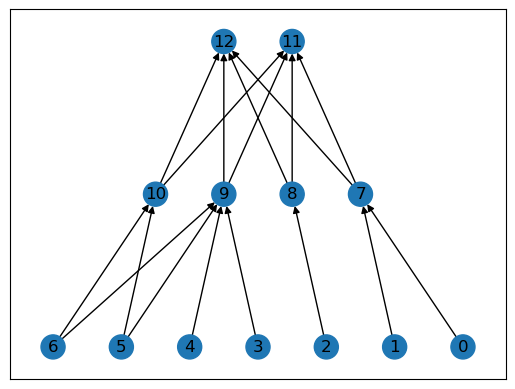

In [4]:
#example pedigrees
#id doesnt matter except for parent child relationships
ped_txt = """\
# id parent0 parent1 time
0 7 7 0.0
1 7 7 0.0
2 8 8 0.0
3 9 9 0.0
4 9 9 0.0
5 10 9 0.0
6 10 9 0.0
7 11 12 1.0
8 11 12 1.0
9 11 12 1.0
10 11 12 1.0
11 . . 2.0
12 . . 2.0
"""

pedigree = msprime.parse_pedigree(io.StringIO(ped_txt), sequence_length = 100)

draw_pedigree(pedigree.tree_sequence())

In [5]:
ped_sim = msprime.sim_ancestry(
    initial_state=pedigree, model="fixed_pedigree", random_seed=42, recombination_rate = 0.001, ploidy = 2)

In [6]:
type(ped_sim)

tskit.trees.TreeSequence

In [102]:
#define functions for building pedigrees for breeding

#transform text to pd df
#df = pd.read_table(io.StringIO(ped_txt))
#transform pd df to text
#print(df.to_string())
##pedigree functions
#generate pedigree df with n "founder" individuals
def pedigree_init(n: int = 10) -> pd.DataFrame:
    """
    Generate a DataFrame representing a pedigree with 'n' founder individuals.

    Parameters:
        n (int): Number of founder individuals.

    Returns:
        pd.DataFrame: DataFrame representing the pedigree.
    """
    pedigree = pd.DataFrame(
    {"id": [i for i in range(0, n)],
    "parent0": ["."]*n,
    "parent1": ["."]*n,
    "time": [0]*n})
    return pedigree

#selfing (adding selfed individual to pedigree)
def add_selfing(df: pd.DataFrame, size_diff: int = 0) -> pd.DataFrame:
    """
    Add selfed individuals (next generation) to the pedigree.

    Parameters:
        df (pd.DataFrame): DataFrame representing the pedigree.
        size_diff (int): Size difference of current and next generation.

    Returns:
        pd.DataFrame: Updated DataFrame with selfed individuals.
    """
    df['time'] += 1
    parents = df.loc[df['time'] == df['time'].min(), "id"].to_numpy()
    max_id = df.loc[df['id'].max(), "id"]
    ids = [i for i in range(max_id + 1, max_id + 1 + len(parents) + size_diff)]
    df = pd.concat(objs=(df, pd.DataFrame({"id" : ids, "parent0": np.resize(parents, len(parents) + size_diff),
                                           "parent1": np.resize(parents, len(parents) + size_diff),
                                           "time" : [0]*(len(parents) + size_diff)}))).reset_index(drop = True)
    return(df)

#parent0: np.resize+np.random.choice where len + size diff is rounded by selfing fraction for one vec, other is filled up to meet 
#size = len(parents)+size_diff - size(self/random)
#make parent0/1 in new line

#random mating
#implement chance of selfing
def add_random_mating(df: pd.DataFrame, size_diff: int = 0, selfing_rate: int = 0) -> pd.DataFrame:
    """
    Add individuals from random mating (next generation) to the pedigree.

    Parameters:
        df (pd.DataFrame): DataFrame representing the pedigree.
        size_diff (int): Size difference of current and next generation.
        selfing_rate (int): Specifies rate of guaranteed selfing.

    Returns:
        pd.DataFrame: Updated DataFrame with randomly mated individuals.
    """
    df['time'] += 1
    parents = df.loc[df['time'] == df['time'].min(), "id"].to_numpy()
    max_id = df.loc[df['id'].max(), "id"]
    ids = [i for i in range(max_id + 1, max_id + 1 + len(parents) + size_diff)]
    selfs = int(Decimal((len(parents) + size_diff)*selfing_rate).quantize(Decimal('1'), rounding=ROUND_HALF_UP))
    non_selfs = int(Decimal((len(parents) + size_diff)*(1-selfing_rate)).quantize(Decimal('1'), rounding=ROUND_HALF_DOWN))
    parent0 = np.concatenate([np.resize(parents, selfs), np.random.choice(parents, non_selfs)])
    parent1 = np.concatenate([np.resize(parents, selfs), np.random.choice(parents, non_selfs)])
    df = pd.concat(objs=(df, pd.DataFrame({"id" : ids, "parent0": parent0,
                                           "parent1": parent1,
                                           "time" : [0]*(len(parents) + size_diff)}))).reset_index(drop = True)
    
    return(df)
    
#selective mating
def add_selective_mating(df: pd.DataFrame, parents: Tuple[int, int], offspring: int = 1) -> pd.DataFrame:
    """
    Add selectively mated individuals to the pedigree.

    Parameters:
        df (pd.DataFrame): DataFrame representing the pedigree.
        parents (Tuple[int, int]): IDs of the parents.
        offspring (int): Number of offspring.

    Returns:
        pd.DataFrame: Updated DataFrame with selectively mated individuals.
    """
    df['time'] += 1
    max_id = df.loc[df['id'].max(), "id"]
    ids = [i for i in range(max_id + 1, max_id + 1 + offspring)]
    df = pd.concat(objs=(df, pd.DataFrame({"id": ids, "parent0": np.resize(parents[0], offspring),
                                           "parent1": np.resize(parents[1], offspring),
                                           "time": [0]*offspring}))).reset_index(drop = True)     
    return(df)

def cross_selfing_ped(offspring: int, selfing_genos: int = 5) -> pd.DataFrame:
    """
    Set up pedigree for crossing two founders with arbitrary offspring and selfing generations.

    Parameters:
        offspring (int): Number of offspring.
        selfing_genos (int): Number of selfing generations.

    Returns:
        pd.DataFrame: DataFrame representing the pedigree.
    """
    cs_ped_df = pedigree_init(n = 2) 
    cs_ped_df = add_selective_mating(cs_ped_df, list([0,1]), offspring = offspring)
    for i in range(0, selfing_genos):
        cs_ped_df = add_selfing(cs_ped_df)
    return(cs_ped_df)

#generate msprime trees from df
def df_to_ts(df: pd.DataFrame, seq_len: int = 100) -> tskit.TreeSequence:
    """
    Generate a tree sequence from a DataFrame representing a pedigree.

    Parameters:
        df (pd.DataFrame): DataFrame representing the pedigree.
        seq_len (int): Length of the sequence/chromosome.

    Returns:
        tskit.TreeSequence: Generated tree sequence.
    """
    ped_string = df.to_string(index = False)
    ts_ped = msprime.parse_pedigree(io.StringIO("#" + ped_string), sequence_length = seq_len)
    return ts_ped


In [166]:
df = pedigree_init(5)

In [167]:
df = add_selfing(df)
df = add_random_mating(df, selfing_rate = 0.8)

In [168]:
df

,id,parent0,parent1,time
0,0,.,.,2
1,1,.,.,2
2,2,.,.,2
3,3,.,.,2
4,4,.,.,2
5,5,0,0,1
6,6,1,1,1
7,7,2,2,1
8,8,3,3,1
9,9,4,4,1


In [170]:
df = add_selective_mating(df, list([10,11]), offspring = 5)

In [150]:
test_ts = df_to_ts(df, 100)

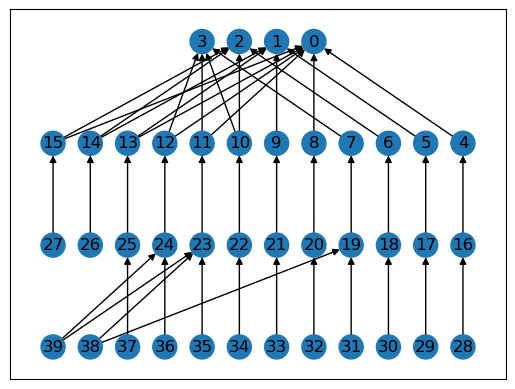

In [151]:
draw_pedigree(test_ts.tree_sequence())

In [12]:
test_arg = msprime.sim_ancestry(
    initial_state=test_ts, model="fixed_pedigree", random_seed=42, recombination_rate = 0)

In [13]:
#print ancestry
def draw_ancestry(ts):
    node_labels = {node.id: f"{node.individual}({node.id})" for node in ts.nodes()}
    SVG(ts.draw_svg(y_axis=True,  node_labels=node_labels, size=(4000,200)))

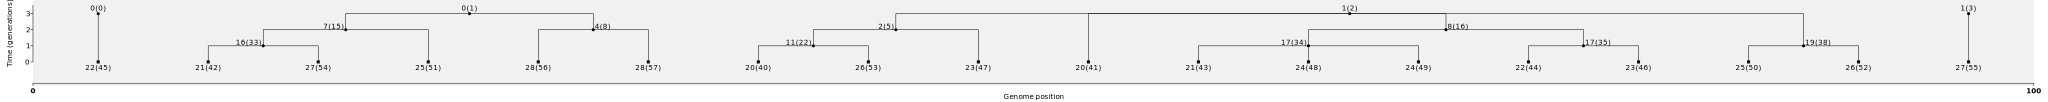

In [14]:
draw_ancestry(test_arg)

In [15]:
test_arg.breakpoints(as_array = True)

array([  0., 100.])

In [16]:
segments = test_arg.ibd_segments(store_pairs = True, store_segments = True)
for pair, value in segments.items():
    print(pair, "::", value)
print(segments)

(40, 41) :: IdentitySegmentList(num_segments=1, total_span=100.0)
(40, 43) :: IdentitySegmentList(num_segments=1, total_span=100.0)
(40, 44) :: IdentitySegmentList(num_segments=1, total_span=100.0)
(40, 46) :: IdentitySegmentList(num_segments=1, total_span=100.0)
(40, 47) :: IdentitySegmentList(num_segments=1, total_span=100.0)
(40, 48) :: IdentitySegmentList(num_segments=1, total_span=100.0)
(40, 49) :: IdentitySegmentList(num_segments=1, total_span=100.0)
(40, 50) :: IdentitySegmentList(num_segments=1, total_span=100.0)
(40, 52) :: IdentitySegmentList(num_segments=1, total_span=100.0)
(40, 53) :: IdentitySegmentList(num_segments=1, total_span=100.0)
(41, 43) :: IdentitySegmentList(num_segments=1, total_span=100.0)
(41, 44) :: IdentitySegmentList(num_segments=1, total_span=100.0)
(41, 46) :: IdentitySegmentList(num_segments=1, total_span=100.0)
(41, 47) :: IdentitySegmentList(num_segments=1, total_span=100.0)
(41, 48) :: IdentitySegmentList(num_segments=1, total_span=100.0)
(41, 49) :

In [280]:
#segments

In [17]:
print(test_arg.dump_tables())

TableCollection

Sequence Length: 100.0
Time units: generations
Metadata: b''

Individuals
╔══╤═════╤════════╤═══════╤═════════════════╗
║id│flags│location│parents│metadata         ║
╠══╪═════╪════════╪═══════╪═════════════════╣
║0 │    0│        │ -1, -1│ {'file_id': '0'}║
║1 │    0│        │ -1, -1│ {'file_id': '1'}║
║2 │    0│        │   1, 1│ {'file_id': '2'}║
║3 │    0│        │   0, 1│ {'file_id': '3'}║
║4 │    0│        │   0, 1│ {'file_id': '4'}║
║5 │    0│        │   1, 1│ {'file_id': '5'}║
║6 │    0│        │   0, 1│ {'file_id': '6'}║
║7 │    0│        │   0, 0│ {'file_id': '7'}║
║8 │    0│        │   1, 1│ {'file_id': '8'}║
║9 │    0│        │   0, 1│ {'file_id': '9'}║
║10│    0│        │   1, 1│{'file_id': '10'}║
║11│    0│        │   2, 2│{'file_id': '11'}║
║12│    0│        │   3, 3│{'file_id': '12'}║
║13│    0│        │   4, 4│{'file_id': '13'}║
║14│    0│        │   5, 5│{'file_id': '14'}║
║15│    0│        │   6, 6│{'file_id': '15'}║
║16│    0│        │   7, 7│{'file_i

In [7]:
#get genos
parent_genos = pd.read_csv("data/test_data/NAM_parent_genos.csv")
#parent_genos

FileNotFoundError: [Errno 2] No such file or directory: 'data/test_data/NAM_parent_genos.csv'

In [283]:
#read_hapmap function to read recombination rates
def get_rate_map(genmap):
    genmap = genmap[["Chromosome", "Position(bp)", "Rate(cM/Mb)", "Map(cM)"]]
    return(msprime.RateMap.read_hapmap(io.StringIO(genmap.to_string(index = False))))

In [284]:
genmap = pd.read_csv("data/test_data/B73_genmap_chr1.csv")
chr1_rate_map = get_rate_map(genmap)

#load snp positions
SNP_positions = pd.read_csv("data/test_data/NAM_SNP_positions.csv")
chr_1_SNP_positions = SNP_positions[SNP_positions["Marker"].isin(genmap["Marker"])]
chr_1_SNP_positions

,Marker,Chromosome,Position(bp)
0,PZA01271.1,1,1947984
1,PZA03613.1,1,2914171
2,PZA02129.1,1,3706018
3,PZA02032.1,1,4490461
4,PHM2244.142,1,5562502
...,...,...,...
171,PZA00243.25,1,295771335
172,PZA00856.2,1,295785198
173,PZA01239.2,1,296854434
174,PZA01807.1,1,297315711


In [293]:
#propagate geno functions
def get_set(ts):
    return(list(set(ts.edges_parent).union(set(ts.edges_child))))

def get_founders(ts):
    return(list(set(ts.edges_parent) - set(ts.edges_child)))

def get_offspring(ts):
    return(list(set(ts.edges_child) - set(ts.edges_parent)))

def get_edges(parents, ts):
    pc_df = pd.DataFrame({"left": ts.edges_left, "right": ts.edges_right, "parent" : ts.edges_parent, "child" : ts.edges_child})
    children = pc_df.loc[pc_df["parent"].isin(parents),]
    return(children)
    
#function to choose founders and split diploid genome into ts nodes -> output genoypes df to use in propagate_geno function
def get_founder_nodes(genotypes, founders):
    founder_geno = genotypes.loc[genotypes['RIL'].isin(founders)].drop("RIL", axis = 1)
    founder_nodes = pd.concat([founder_geno.loc[0].str[0],
                              founder_geno.loc[0].str[2],
                              founder_geno.loc[1].str[0],
                              founder_geno.loc[1].str[2]], axis = 1).T.reset_index(drop = True)
    return founder_nodes

#add typing!!
def propagate_geno(arg, founder_nodes, snp_pos):
    sites = snp_pos["Marker"]
    geno_sim = pd.DataFrame(columns = list(["node"]) + list(sites))
    geno_sim["node"] = get_set(arg)
    founders = get_founders(arg)
    founder_nodes = founder_nodes[sites]
    
    for i in range(0, len(founders)):
        geno_sim.loc[geno_sim["node"] == founders[i], sites] = list(founder_nodes.iloc[founders[i]])

    edges = get_edges(founders, arg)

    while edges.empty != True:
        for i in range(0, len(edges["parent"])):
            snps = snp_pos.loc[(snp_pos['Position(bp)'] >= edges.iloc[i]["left"]) & (snp_pos['Position(bp)'] <= edges.iloc[i]["right"]), "Marker"]
            geno_sim.loc[geno_sim["node"] == edges.iloc[i]["child"], snps] = geno_sim.loc[geno_sim["node"] == edges.iloc[i]["parent"], snps].values[0]
        edges = get_edges(edges["child"], arg)

    
    return(geno_sim)

def get_offspring_geno(arg, geno_sim):
    return(geno_sim.loc[geno_sim["node"].isin(get_offspring(arg))])

In [294]:
founder_nodes = get_founder_nodes(parent_genos, list(["B73", "B97"]))

In [242]:
#genmap = genmap.loc[genmap['Position(bp)'] <= 10000000]

In [295]:
geno_sim = propagate_geno(test_arg, founder_nodes, chr_1_SNP_positions)

In [296]:
get_offspring_geno(test_arg, geno_sim)

,node,PZA01271.1,PZA03613.1,PZA02129.1,PZA02032.1,PHM2244.142,PZA02372.1,PHM6238.36,PZA00181.2,PZA00528.1,...,PZA02359.10,PHM9807.9,PZA01068.1,PZA00343.31,PHM1275.22,PZA00243.25,PZA00856.2,PZA01239.2,PZA01807.1,PZA00432.4
58,58,G,T,C,A,C,T,A,G,A,...,T,G,C,A,A,G,T,A,G,C
59,59,G,T,C,T,C,T,A,T,C,...,T,C,C,A,A,G,T,A,G,C
60,60,G,T,C,A,G,T,A,T,C,...,T,G,C,G,C,A,T,A,G,T
61,61,G,T,C,A,G,T,A,T,C,...,T,G,C,G,C,A,T,A,G,T
62,62,C,A,T,T,C,T,A,G,A,...,T,G,C,G,C,A,T,A,G,T
63,63,C,A,T,T,C,T,A,G,A,...,T,G,C,G,C,A,T,A,G,T
64,64,C,A,T,T,C,T,A,G,A,...,T,C,C,A,A,G,T,A,G,T
65,65,C,A,C,T,C,T,A,G,A,...,T,C,C,A,A,G,T,A,G,T
66,66,C,A,T,T,C,T,A,G,A,...,T,C,C,A,A,G,T,A,G,C
67,67,C,A,T,T,C,T,A,G,A,...,T,C,C,A,A,G,T,A,G,C


In [222]:
sites = genmap["Marker"]

In [223]:
geno_sim = pd.DataFrame(columns = list(["node"]) + list(sites))

In [224]:
geno_sim["node"] = get_set(test_arg)

In [225]:
founders = get_founders(test_arg)

In [226]:
founder_nodes = get_founder_nodes(parent_genos, list(["B73", "B97"]))

In [227]:
founder_nodes = founder_nodes[sites]

In [228]:
for i in range(0, len(founders)):
        geno_sim.loc[geno_sim["node"] == founders[i], sites] = list(founder_nodes.iloc[founders[i]])

In [229]:
geno_sim

,node,PZA01271.1,PZA03613.1,PZA02129.1,PZA02032.1,PHM2244.142,PZA02372.1,PHM6238.36,PZA00181.2,PZA00528.1,PZA00175.2,PZA00447.8,PZA02284.1,PZA00731.7
0,0,C,A,T,T,C,T,A,G,A,T,C,C,A
1,1,C,A,T,T,C,T,A,G,A,T,C,C,A
2,2,G,T,C,A,G,T,A,T,C,T,T,C,A
3,3,G,T,C,A,G,T,A,T,C,T,T,C,A
4,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [230]:
edges = get_edges(founders, test_arg)

In [231]:
edges

,left,right,parent,child
28,0.0,2251651.0,0,5
29,1884721.0,3769125.0,0,7
30,4939488.0,5604364.0,0,7
31,8657.0,2251239.0,0,15
32,6281836.0,10000000.0,0,15
33,0.0,4150518.0,0,18
34,2251651.0,5214090.0,0,22
35,0.0,1884721.0,0,24
36,3769125.0,4939488.0,0,24
37,5604364.0,10000000.0,0,24


In [232]:
for i in range(0, len(edges["parent"])):
    snps = genmap.loc[(genmap['Position(bp)'] >= edges.iloc[i]["left"]) & (genmap['Position(bp)'] <= edges.iloc[i]["right"]), "Marker"]
    geno_sim.loc[geno_sim["node"] == edges.iloc[i]["child"], snps] = geno_sim.loc[geno_sim["node"] == edges.iloc[i]["parent"], snps].values[0]

In [40]:
#snps = genmap.loc[(genmap['Position(bp)'] >= edges.iloc[0]["left"]) & (genmap['Position(bp)'] <= edges.iloc[0]["right"]), "Marker"]

In [41]:
#geno_sim.loc[geno_sim["node"] == edges.iloc[0]["child"], snps] = geno_sim.loc[geno_sim["node"] == edges.iloc[0]["parent"], snps].values[0]


In [233]:
genmap

,Marker,Chromosome,Position(bp)
0,PZA01271.1,1,1947984
1,PZA03613.1,1,2914171
2,PZA02129.1,1,3706018
3,PZA02032.1,1,4490461
4,PHM2244.142,1,5562502
5,PZA02372.1,1,6220547
6,PHM6238.36,1,7156367
7,PZA00181.2,1,8366411
8,PZA00528.1,1,8367944
9,PZA00175.2,1,8510027


In [234]:
geno_sim

,node,PZA01271.1,PZA03613.1,PZA02129.1,PZA02032.1,PHM2244.142,PZA02372.1,PHM6238.36,PZA00181.2,PZA00528.1,PZA00175.2,PZA00447.8,PZA02284.1,PZA00731.7
0,0,C,A,T,T,C,T,A,G,A,T,C,C,A
1,1,C,A,T,T,C,T,A,G,A,T,C,C,A
2,2,G,T,C,A,G,T,A,T,C,T,T,C,A
3,3,G,T,C,A,G,T,A,T,C,T,T,C,A
4,4,NaN,NaN,NaN,NaN,G,T,A,T,C,T,T,C,A
5,5,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,C,A,T,NaN,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,G,T,C,A,G,T,A,T,C,T,T,C,A
8,11,G,T,C,A,G,T,A,T,C,T,T,C,A
9,15,C,NaN,NaN,NaN,NaN,NaN,A,G,A,T,C,C,A


In [235]:
edges = get_edges(edges["child"], test_arg)

In [236]:
for i in range(0, len(edges["parent"])):
    snps = genmap.loc[(genmap['Position(bp)'] >= edges.iloc[i]["left"]) & (genmap['Position(bp)'] <= edges.iloc[i]["right"]), "Marker"]
    geno_sim.loc[geno_sim["node"] == edges.iloc[i]["child"], snps] = geno_sim.loc[geno_sim["node"] == edges.iloc[i]["parent"], snps].values[0]

In [237]:
geno_sim

,node,PZA01271.1,PZA03613.1,PZA02129.1,PZA02032.1,PHM2244.142,PZA02372.1,PHM6238.36,PZA00181.2,PZA00528.1,PZA00175.2,PZA00447.8,PZA02284.1,PZA00731.7
0,0,C,A,T,T,C,T,A,G,A,T,C,C,A
1,1,C,A,T,T,C,T,A,G,A,T,C,C,A
2,2,G,T,C,A,G,T,A,T,C,T,T,C,A
3,3,G,T,C,A,G,T,A,T,C,T,T,C,A
4,4,NaN,NaN,NaN,NaN,G,T,A,T,C,T,T,C,A
5,5,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,C,A,T,NaN,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,G,T,C,A,G,T,A,T,C,T,T,C,A
8,11,G,T,C,A,G,T,A,T,C,T,T,C,A
9,15,C,NaN,NaN,NaN,NaN,NaN,A,G,A,T,C,C,A


In [238]:
get_edges(edges["child"], test_arg)

,left,right,parent,child


In [239]:
geno_sim.loc[geno_sim["node"].isin(get_offspring(test_arg))]

,node,PZA01271.1,PZA03613.1,PZA02129.1,PZA02032.1,PHM2244.142,PZA02372.1,PHM6238.36,PZA00181.2,PZA00528.1,PZA00175.2,PZA00447.8,PZA02284.1,PZA00731.7
14,22,C,A,T,T,G,T,A,T,C,T,T,C,A
15,23,C,T,C,A,G,T,A,T,C,T,T,C,A
16,24,C,A,T,T,C,T,A,G,A,T,C,C,A
17,25,C,A,T,A,C,T,A,T,C,T,T,C,A
18,26,G,T,C,A,G,T,A,T,C,T,T,C,A
19,27,G,T,C,A,G,T,A,T,C,T,T,C,A
20,28,G,T,C,A,G,T,A,T,C,T,T,C,A
21,29,G,T,C,A,G,T,A,T,C,T,T,C,A
22,30,C,A,T,T,C,T,A,G,A,T,C,C,A
23,31,C,A,T,T,C,T,A,G,A,T,C,C,A


In [33]:
print(ped_ts.dump_tables())

TableCollection

Sequence Length: 100.0
Time units: generations
Metadata: b''

Individuals
╔══╤═════╤════════╤═══════╤═════════════════╗
║id│flags│location│parents│metadata         ║
╠══╪═════╪════════╪═══════╪═════════════════╣
║0 │    0│        │ -1, -1│ {'file_id': '0'}║
║1 │    0│        │ -1, -1│ {'file_id': '1'}║
║2 │    0│        │ -1, -1│ {'file_id': '2'}║
║3 │    0│        │ -1, -1│ {'file_id': '3'}║
║4 │    0│        │ -1, -1│ {'file_id': '4'}║
║5 │    0│        │   0, 0│ {'file_id': '5'}║
║6 │    0│        │   1, 1│ {'file_id': '6'}║
║7 │    0│        │   2, 2│ {'file_id': '7'}║
║8 │    0│        │   3, 3│ {'file_id': '8'}║
║9 │    0│        │   4, 4│ {'file_id': '9'}║
║10│    0│        │   5, 5│{'file_id': '10'}║
║11│    0│        │   6, 6│{'file_id': '11'}║
║12│    0│        │   7, 7│{'file_id': '12'}║
║13│    0│        │   8, 8│{'file_id': '13'}║
║14│    0│        │   9, 9│{'file_id': '14'}║
║15│    0│        │ 10, 10│{'file_id': '15'}║
║16│    0│        │ 11, 11│{'file_i

In [20]:
#selection step (see essentials of plant breeding) prune pedigree
#either stepwise (prediction and selection in each step with caveats (only possible in selfing generations))
#or simulate entire breeding ibds and predict final phenotype, simulate all generations

In [21]:
#predict Y (see rf or dl files)

In [ ]:
#tskit examples

In [51]:
nodes = """\
id      is_sample   time
0       1           0
1       1           0
2       1           0
3       1           0
4       1           0
5       0           1
6       0           2
7       0           3
"""
edges = """\
left    right   parent  child
0       60      5       4,3
0       40      6       2
0       60      6       1,0
20      40      6       5
0       20      7       5
40      60      7       5
0       60      7       6
40      60      7       2
"""
sites = """\
position	ancestral_state	metadata
2.000000	A	
4.000000	A	
"""

In [52]:
sites_ts = tskit.load_text(nodes = io.StringIO(nodes), edges = io.StringIO(edges), sites = io.StringIO(sites), strict = False)

In [137]:
ped_ts.dump_tables().sites

id,position,ancestral_state,metadata


In [180]:
print(ped_ts.dump_tables())

TableCollection

Sequence Length: 100.0
Time units: generations
Metadata: b''

Individuals
╔══╤═════╤════════╤═══════╤════════════════╗
║id│flags│location│parents│metadata        ║
╠══╪═════╪════════╪═══════╪════════════════╣
║0 │    0│        │ -1, -1│{'file_id': '0'}║
║1 │    0│        │ -1, -1│{'file_id': '1'}║
║2 │    0│        │ -1, -1│{'file_id': '2'}║
║3 │    0│        │ -1, -1│{'file_id': '3'}║
║4 │    0│        │ -1, -1│{'file_id': '4'}║
║5 │    0│        │   4, 2│{'file_id': '5'}║
║6 │    0│        │   4, 2│{'file_id': '6'}║
║7 │    0│        │   3, 0│{'file_id': '7'}║
║8 │    0│        │   1, 2│{'file_id': '8'}║
║9 │    0│        │   2, 4│{'file_id': '9'}║
╚══╧═════╧════════╧═══════╧════════════════╝

Nodes
╔══╤═════╤══════════╤══════════╤════╤════════╗
║id│flags│population│individual│time│metadata║
╠══╪═════╪══════════╪══════════╪════╪════════╣
║0 │    0│         0│         0│   1│        ║
║1 │    0│         0│         0│   1│        ║
║2 │    0│         0│         1│   1│

In [181]:
for i, h in enumerate(ped_ts.haplotypes()):
    print(f"Sample {i}: {h}")

Sample 0: AGT
Sample 1: AGT
Sample 2: AGT
Sample 3: AGT
Sample 4: AGT
Sample 5: AGT
Sample 6: AGT
Sample 7: AGT
Sample 8: AGT
Sample 9: AGT


In [27]:
sites_ts.roots()

AttributeError: 'TreeSequence' object has no attribute 'roots'